# Inversion of Frequency Domain EM data: Bookpurnong Australia

This example is based on the inversion published of RESOLVE data over in [Heagy et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0098300416303946)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
from SimPEG import Utils, Mesh

In [2]:
from matplotlib import rcParams
rcParams['font.size']=14

## Look at the contents of the data directory we are given

In [3]:
data_directory = "bookpurnong"
os.listdir(data_directory)

['MurrayRiver.txt',
 '8044_Bookpurnong.HDR',
 'SK655CS_Bookpurnong_ZX_HM_TxInc_newDTM.txt',
 'README.txt',
 'Bookpurnong_SkyTEM.HDR',
 'Bookpurnong_Resolve_Exported.XYZ']

### look at the README for a description of the files

In [4]:
# the os.path.sep.join combines the "bookpurnong" and "README.txt" with the 
# correct path seperator (e.g. on mac or linux, this will produce 
# "bookpurnong/README.txt")

with open(os.path.sep.join([data_directory, "README.txt"]), 'r') as file:
    print(file.read())

Bookpurnong Data Sets

The RESOLVE and SkyTEM data collected over Bookpurnong have been made available with permission from CSIRO. Please acknowledge CSIRO if using these data in a presentation, publication, etc.

Two data sets are included in this distribution, RESOLVE data collected in 2008, and SkyTEM (High Moment) data collected in 2006.

For an example of how to load and plot the data, please see: http://docs.simpeg.xyz


Contents
--------

- 8044_Bookpurnong.HDR : RESOLVE header file for the 2008 Bookpurnong survey
- Bookpurnong_Resolve_Exported.XYZ : RESOLVE data collected in 2008
- Bookpurnong_SkyTEM.HDR : SkyTEM header file for the 2006 Bookpurnong survey
- SK655CS_Bookpurnong_ZX_HM_TxInc_newDTM.txt : SkyTEM high moment data collected in 2006






### Load the resolve data

In [5]:
# Load RESOLVE (2008)
header = "Survey     Date   Flight      fid  utctime helicopter_easting helicopter_northing gps_height bird_easting bird_northing bird_gpsheight elevation bird_height bird_roll bird_pitch bird_yaw    em[0]    em[1]    em[2]    em[3]    em[4]    em[5]    em[6]    em[7]    em[8]    em[9]   em[10]   em[11]       Line "
header = header.split()
resolve = np.loadtxt(
    os.path.sep.join([data_directory, "Bookpurnong_Resolve_Exported.XYZ"]),
    skiprows=8
)
lines = np.unique(resolve[:, -1])


In [6]:
# Load path of Murray River
river_path = np.loadtxt(os.path.sep.join([data_directory, "MurrayRiver.txt"]))

In [8]:
def get_column_index(header_key, header=header):
    ind = None
    for i, key in enumerate(header): 
        if key == header_key:
            ind = i
    return ind

In [9]:
easting = resolve[:, get_column_index("bird_easting")]
northing = resolve[:, get_column_index("bird_northing")]

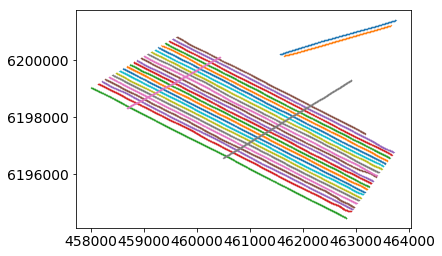

In [10]:
fig, ax = plt.subplots(1, 1)
for l in lines:
    inds = resolve[:, -1] == l
    ax.plot(easting[inds], northing[inds], '.', ms=0.5)

# ax.plot(river_path[:, 0], river_path[:, 1], 'k', lw=0.5)

In [11]:
lines

array([30001., 30002., 30010., 30030., 30040., 30050., 30060., 30070.,
       30080., 30090., 30100., 30110., 30120., 30130., 30140., 30151.,
       30160., 30170., 30180., 30190., 30200., 30210., 30220., 30230.,
       30240., 30250., 39010., 39020.])

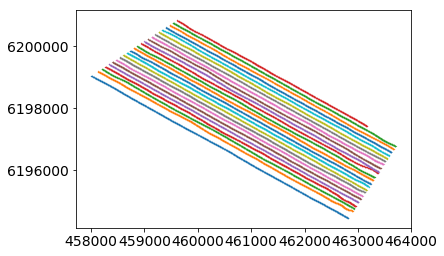

In [12]:
# Omit the tie lines
fig, ax = plt.subplots(1, 1)
for l in lines[2:-2]:
    inds = resolve[:, -1] == l
    ax.plot(easting[inds], northing[inds], '.', ms=0.5)

# ax.plot(river_path[:, 0], river_path[:, 1], 'k', lw=0.5)

In [13]:
tie_line_inds = (resolve[:, -1] <= lines[2]) | (resolve[:, -1] >= lines[-2])

In [14]:
data_header = "CPI400_F  CPQ400_F  CPI1800_F CPQ1800_F CXI3300_F CXQ3300_F CPI8200_F CPQ8200_F CPI40k_F  CPQ40k_F  CPI140k_F CPQ140k_F "
data_header = data_header.split()

xyz = resolve[~tie_line_inds, 8:11]
data = resolve[~tie_line_inds, 16:-1]

In [42]:
def plot_data(header_ind):
    fig, ax = plt.subplots(1,1, figsize = (8,8))
    
    # grid the data
    nskip = 40
    out = Utils.plot2Ddata(xyz[::nskip, :2], data[::nskip, header_ind], ncontour=100, ax=ax)
    plt.colorbar(out[0], ax=ax, label="Bz (ppm)")
    
    # add the river path 
    ax.plot(river_path[:, 0], river_path[:, 1], 'k', lw=0.5)
    
    # labels
    ax.set_xlabel('easting (m)')
    ax.set_ylabel('northing (m)')
    
    # get title
    head = data_header[header_ind]
    orientation = head[:2]
    
    component = None
    if head[2] == "I":
        component = "in-phase" 
    elif head[2] == "Q":
        component = "quadrature"
    
    freq = head.split("_")[0][3:]
    
    ax.set_title(f"{orientation}, {freq}Hz {component}")
    return ax

In [43]:
ipywidgets.interact(
    plot_data, 
    header_ind = ipywidgets.IntSlider(min=0, max=len(data_header)-1, value=0)
)

interactive(children=(IntSlider(value=0, description='header_ind', max=11), Output()), _dom_classes=('widget-i…

<function __main__.plot_data(header_ind)>

## invert a single sounding

Here, we will invert a single sounding location for a layered earth and use a cylindrically symmetric mesh for the forward modelling. 

In [87]:
xloc, yloc = 462100.0, 6196500.0

In [88]:
rxind = np.argmin((xyz[:, 0]-xloc)**2+(xyz[:, 1]-yloc)**2)
print(rxind)

15007


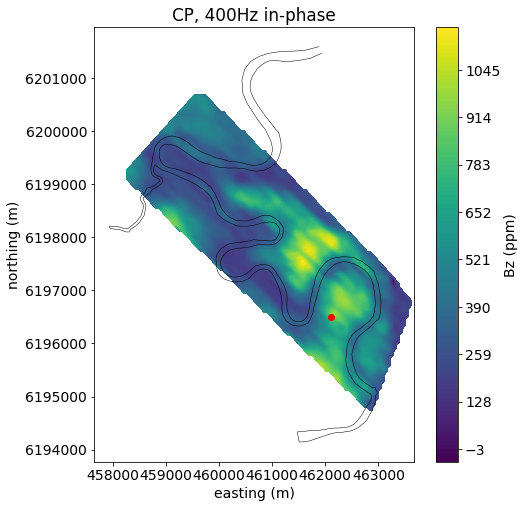

In [89]:
# plot the location
ax = plot_data(0)
ax.plot(xyz[rxind, 0], xyz[rxind, 1], 'ro')

In [90]:
coplanar_inds = [False]*len(data_header)

for i, head in enumerate(data_header):
    if head.startswith("CP"):
        coplanar_inds[i] = True
        
coplanar_data = data[:, coplanar_inds]

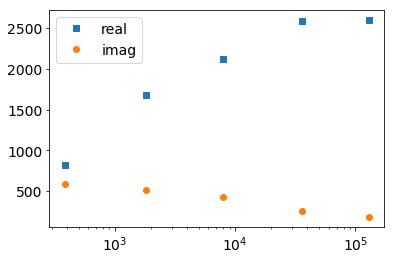

In [91]:
# plot the data - lets only work with the co-planar data set
frequencies = [382, 1822, 7970, 35920, 130100]
fig, ax = plt.subplots(1, 1)

for i, freq in enumerate(frequencies):
    # in phase is listed first
    ax.semilogx(freq, coplanar_data[rxind, i*2], 'C0s', ms=6)
    ax.semilogx(freq, coplanar_data[rxind, i*2 + 1], 'C1o', ms=6)

ax.legend(["real", "imag"])